In [1]:
from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np


#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

filepath=r'dataset/df_msg_encoded.csv'

file_tag = 'df_msg_MV'

# Load

In [2]:
# test_data=True
test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 1% sample
    data=data.sample(frac=0.01, replace=False)
    

else:
    data=pd.read_csv(filepath)
    # 50% sample
    data=data.sample(frac=0.1, replace=False)

 
target='is_clicked'

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True) 

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461961 entries, 328579 to 4616329
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   platform                      33328 non-null   float64
 1   email_provider                250519 non-null  float64
 2   is_clicked                    461961 non-null  float64
 3   campaign_type                 461961 non-null  float64
 4   channel_cmp                   461961 non-null  float64
 5   topic                         458332 non-null  float64
 6   total_count                   352947 non-null  float64
 7   subject_length                376928 non-null  float64
 8   subject_with_personalization  376928 non-null  float64
 9   subject_with_deadline         376928 non-null  float64
 10  subject_with_emoji            376928 non-null  float64
 11  subject_with_bonuses          376928 non-null  float64
 12  subject_with_discount         376928 non-nu

# DSLabs functions

In [3]:
%run "scripts/dslabs_functions.py"

dslabs lodaded


In [4]:
%run "scripts/data_functions.py"

dslabs lodaded
data_functions lodaded


In [5]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, show
#from dslabs_functions import plot_bar_chart

# MV Analysis

Variables with their respective percentages of missing values:
platform: 92.75%
email_provider: 45.79%
total_count: 23.49%
subject_length: 18.30%
subject_with_personalization: 18.30%
subject_with_deadline: 18.30%
subject_with_emoji: 18.30%
subject_with_bonuses: 18.30%
subject_with_discount: 18.30%
subject_with_saleout: 18.30%
topic: 0.77%


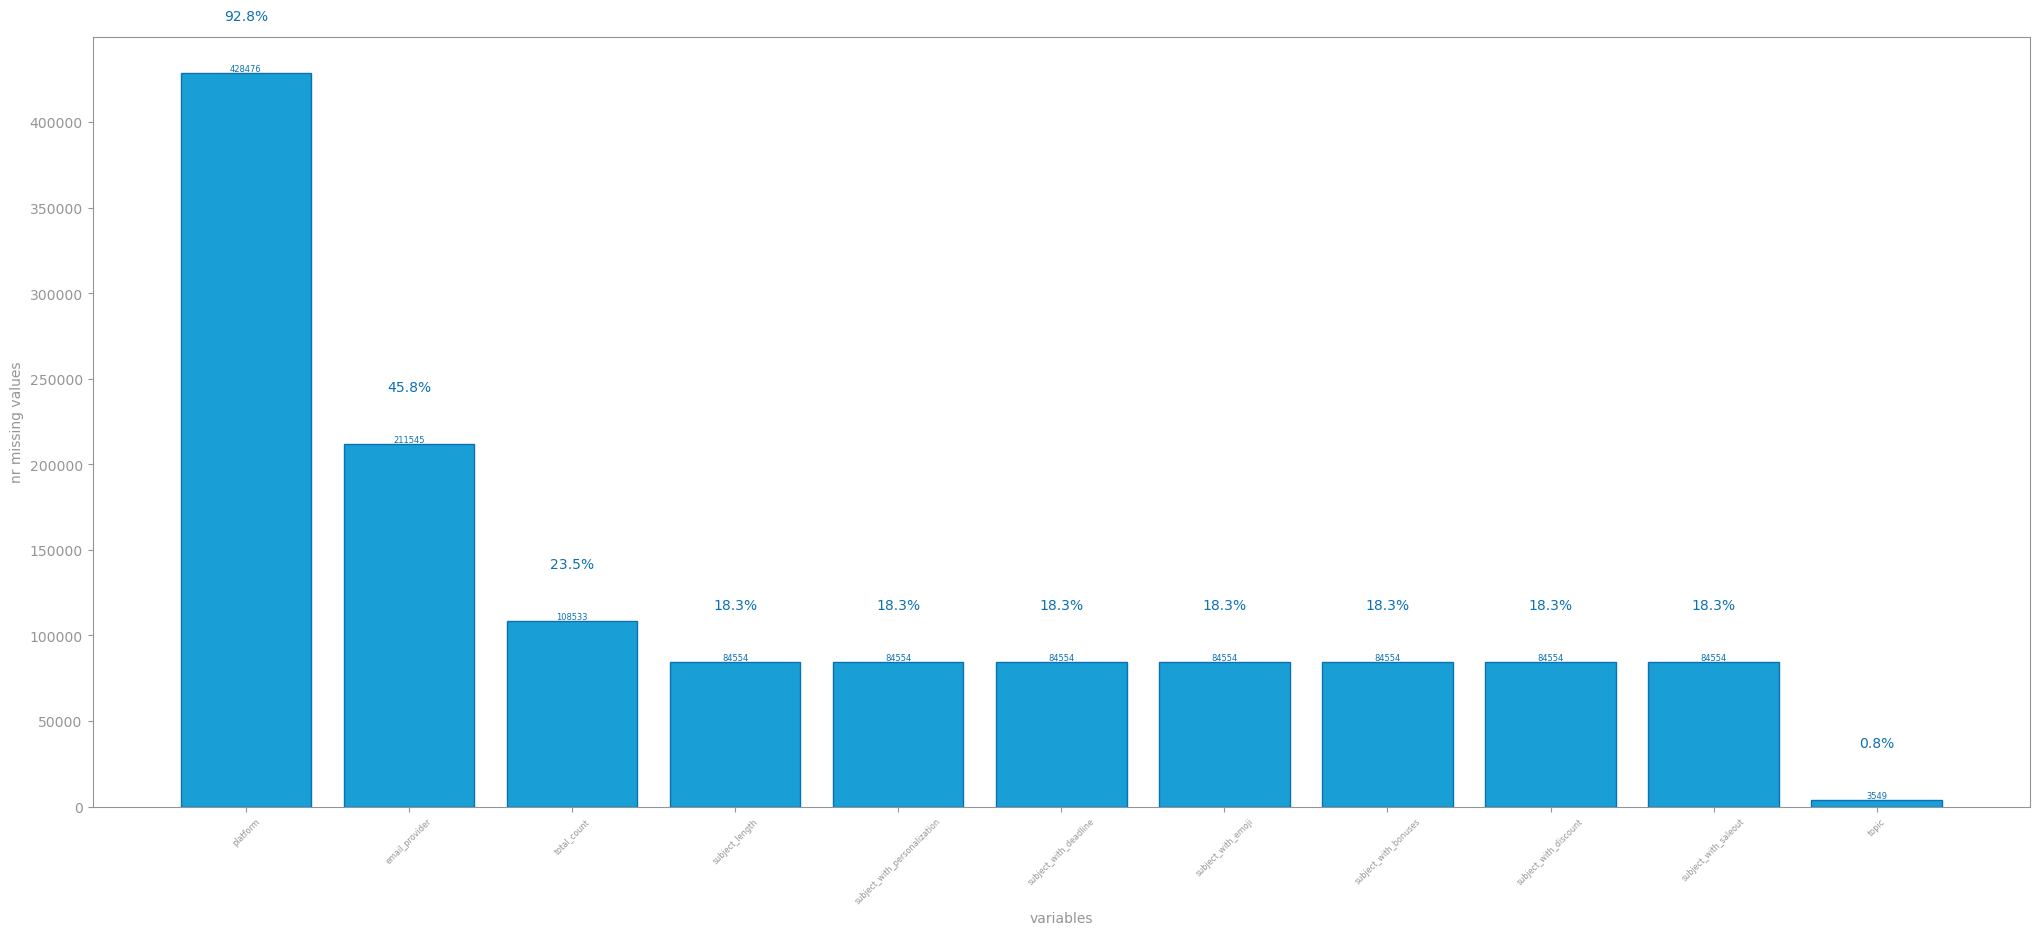

In [36]:
mv: dict[str, int] = {}
total_rows = len(data)

# Calculate the number of missing values and percentage for each variable
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

# Sort the dictionary by the number of missing values in descending order
sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

# Print the list of variables with their respective percentages of missing values
print("Variables with their respective percentages of missing values:")
for var, perc in zip(variables, percentages):
    print(f"{var}: {perc:.2f}%")

# Plotting the bar chart
figure(figsize=(25, 10))  # (width, height)

plot_bar_chart(
    variables,
    missing_values,
    xlabel="variables",
    ylabel="nr missing values",
)

# Annotate the bars with percentages
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

# Display the chart
show()


In [37]:
#data = data.drop(columns=['days_diff_complained_at_sent_at','days_diff_purchased_at_sent_at', "platform", "email_provider",
#                            "days_diff_clicked_first_time_at_sent_at",
#                           "days_diff_opened_first_time_at_sent_at", "days_diff_first_purchase_date_sent_at"])

In [38]:
data.shape[0]

461961

In [39]:
data.columns

Index(['platform', 'email_provider', 'is_clicked', 'campaign_type',
       'channel_cmp', 'topic', 'total_count', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'day_of_year', 'is_weekend', 'month',
       'time_of_day', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'day_of_month_sin', 'day_of_month_cos', 'day_of_week_nr_sin',
       'day_of_week_nr_cos', 'week_of_month_sin', 'week_of_month_cos'],
      dtype='object')

# Strategies

Recall is important when you are looking at minimizing the number of false negatives. For example, let’s assume you are using the model to select customers for an email campaign. You would want to maximize the number of customers the model correctly predicts to purchase the product and you would want to only target customers who will be interested in purchasing the product. In this case, recall is a more appropriate evaluation metric

# MV 1 - Most Frequent Srategy

## MV1 strategy apply

In [6]:
from numpy import ndarray
from pandas import concat
from sklearn.impute import SimpleImputer, KNNImputer
from dslabs_functions import get_variable_types, mvi_by_filling

# this script is available in data_functions originally from DSLabs site in Missing Values chapter

def apply_strategy_1(df):

    data_copy=data.copy()
    data_copy = mvi_by_filling(data_copy, strategy="frequent")

    return data_copy

data_1=apply_strategy_1(data)
data_1.describe()


,platform,email_provider,campaign_type,channel_cmp,topic,total_count,subject_length,day_of_year,month,hour_sin,...,week_of_month_cos,is_clicked,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_weekend,time_of_day
count,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,4.619610e+05,461961.000000,461961.000000,461961.000000,461961.000000,...,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000
mean,2.287206,1.704861,0.420051,1.273625,13.295528,6.326919e+05,108.179976,138.097943,1.026465,0.589148,...,-0.033921,0.020751,0.000719,0.029589,0.966121,0.018032,0.003463,0.025249,0.078450,0.146227
std,0.340141,3.071600,0.782144,0.752924,3.653979,3.377834e+05,21.120672,12.048713,0.521813,0.496285,...,0.628828,0.142549,0.026799,0.169451,0.180919,0.133067,0.058750,0.156880,0.268879,0.353334
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+00,32.000000,120.000000,0.000000,-0.942000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.287206,1.000000,0.000000,1.000000,15.000000,2.746330e+05,97.000000,126.000000,1.000000,0.631000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.287206,1.704861,0.000000,1.000000,15.000000,6.326919e+05,108.179976,140.000000,1.000000,0.817000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.287206,1.704861,0.000000,2.000000,15.000000,9.218380e+05,115.000000,147.000000,1.000000,0.942000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,197.000000,2.000000,2.000000,17.000000,1.045217e+06,185.000000,165.000000,2.000000,0.998000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
data_1.columns

Index(['platform', 'email_provider', 'campaign_type', 'channel_cmp', 'topic',
       'total_count', 'subject_length', 'day_of_year', 'month', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_sin', 'week_of_month_cos', 'is_clicked',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'is_weekend', 'time_of_day'],
      dtype='object')

## MV1 train/test split 

Labels=[0.0, 1.0]


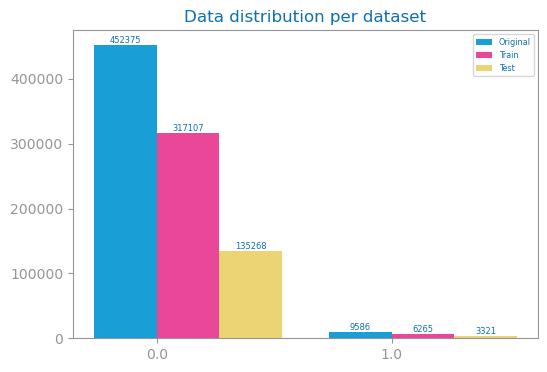

In [7]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
#from dslabs_functions import plot_multibar_chart
from numpy import array, ndarray


y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)


# Call the function to split the data
train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

In [43]:
data_1.shape[0]

461961

## MV1 evaluate

<Figure size 640x480 with 0 Axes>

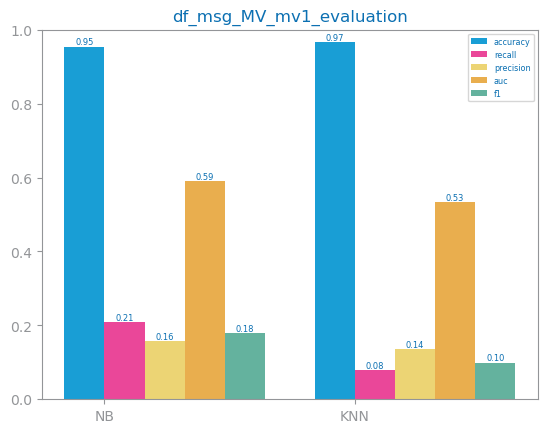

In [8]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
#from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_clicked', metric="recall")

if not eval_1 or all(len(values) == 0 for values in eval_1.values()):
    print("No data available to plot. Please check the input data.")
else:
    figure()
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_mv1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_mv1_evaluation.png")
    show()

In [9]:
print("Evaluation data:", eval_1)


Evaluation data: {'accuracy': [0.9542099300810309, 0.9659063850666358], 'recall': [0.20897320084311954, 0.07859078590785908], 'precision': [0.15726263312939043, 0.13551401869158877], 'auc': [0.5907398162597476, 0.5331409440081332], 'f1': [0.17946728730281872, 0.09948542024013722]}


# MV2 - drop null strategy - columns

1. Remove 7 variables due to high % of null values. Also, since we are not sure of its quality it makes more sense to remove it altogether without sacrificing the number of rows
2. Remove remaining null values records 

## MV2 strategy apply

In [47]:
# numeric_vars: list[str] = get_variable_types(data)["numeric"]

def apply_strategy_2(df):

    df_copy=df.copy()

    df_copy = df_copy.dropna(axis=1, how="any") #axis=1, drop columns that contain any missing values.

    return df_copy

data_2=apply_strategy_2(data)

## MV2 target prep

In [48]:
y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)


Labels=[0.0, 1.0]


## MV2 train/test split 

<Axes: title={'center': 'Data distribution per dataset'}>

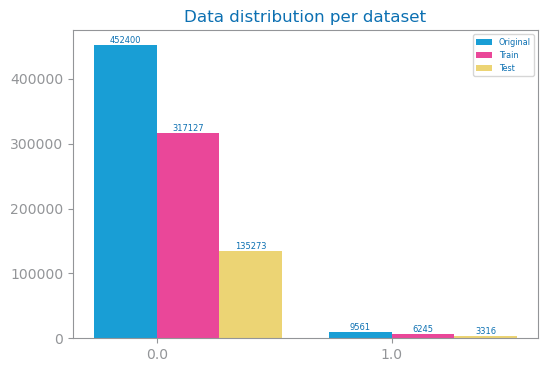

In [49]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
#from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## MV2 evaluate

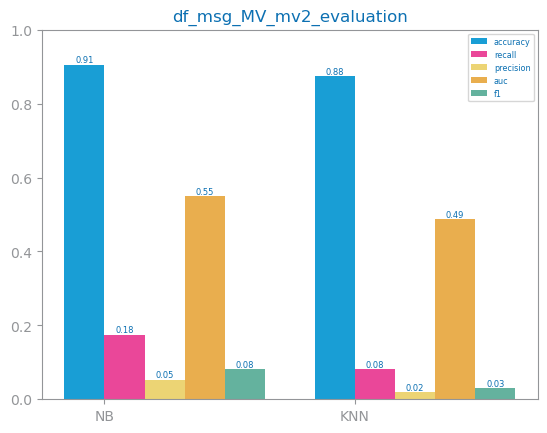

In [50]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_clicked', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_mv2_evaluation", percentage=True
)
savefig(f"images/{file_tag}mv2_evaluation.png")
show()

# MV3 - drop null strategy - rows

1. Remove 7 variables due to high % of null values. Also, since we are not sure of its quality it makes more sense to remove it altogether without sacrificing the number of rows
2. Remove remaining null values records 

## MV3 strategy apply

In [12]:
# numeric_vars: list[str] = get_variable_types(data)["numeric"]

def apply_strategy_3(df):

    df_copy=df.copy()
    df_copy = df_copy.dropna(axis=0, how="any") #axis=0 tells dropna to remove rows that have at least one NaN value.

    return df_copy

data_3=apply_strategy_3(data)

## MV3 target prep

In [13]:
y_3, X_3, labels, class_counts = define_target_and_prepare_data(data_3, target=target)


Labels=[0.0, 1.0]


## MV3 train/test split 

<Axes: title={'center': 'Data distribution per dataset'}>

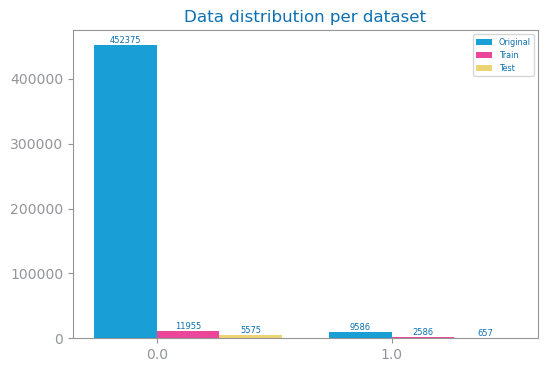

In [14]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
#from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
train_3, test_3 = split_data_save_csv(pd.DataFrame(X_3, columns=data_3.columns), y_3, data_columns=data_3.columns, target_column=target)


values["Train"] = [
    len(train_3[train_3[target] == 0]),
    len(train_3[train_3[target] == 1]),
]
values["Test"] = [
    len(test_3[test_3[target] == 0]),
    len(test_3[test_3[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## MV3 evaluate

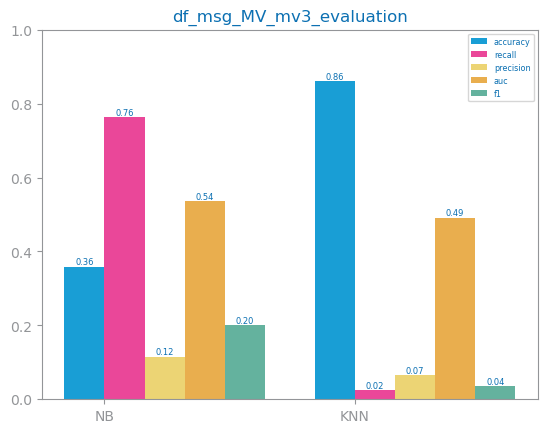

In [15]:

figure()
eval_3: dict[str, list] = evaluate_approach(train_3, test_3, target='is_clicked', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_3, title=f"{file_tag}_mv3_evaluation", percentage=True
)
savefig(f"images/{file_tag}mv3_evaluation.png")
show()

In [16]:
data_3.shape[0]

20773

# MV4 - knn strategy

## MV4 strategy apply
haven't been able to run it. very computationally heavy and takes way too long 1h++

In [18]:
from numpy import ndarray
from pandas import concat
from sklearn.impute import SimpleImputer, KNNImputer
#from dslabs_functions import get_variable_types, mvi_by_filling

# this script is available in data_functions originally from DSLabs site in Missing Values chapter

def apply_strategy_4(df):

    data_copy=data.copy()
    data_copy = mvi_by_filling(data_copy, strategy="knn")

    return data_copy

data_4=apply_strategy_4(data)
data_4.describe()


,platform,email_provider,is_clicked,campaign_type,channel_cmp,topic,total_count,subject_length,subject_with_personalization,subject_with_deadline,...,hour_sin,hour_cos,min_sin,min_cos,day_of_month_sin,day_of_month_cos,day_of_week_nr_sin,day_of_week_nr_cos,week_of_month_sin,week_of_month_cos
count,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,4.619610e+05,461961.000000,461961.000000,461961.000000,...,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000,461961.000000
mean,2.345305,1.591810,0.020751,0.420051,1.273625,13.254017,5.281413e+05,109.863881,0.000719,0.030657,...,0.589148,-0.570184,-0.017634,0.029771,0.014620,0.090171,-0.074634,-0.385809,0.188910,-0.033921
std,0.758593,3.093726,0.142549,0.782144,0.752924,3.684828,4.092083e+05,22.714096,0.026799,0.171932,...,0.496285,0.285607,0.672771,0.739072,0.729943,0.677463,0.642465,0.657874,0.753485,0.628828
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+00,32.000000,0.000000,0.000000,...,-0.942000,-0.991000,-1.000000,-0.999000,-0.999000,-0.995000,-0.866000,-1.000000,-1.000000,-1.000000
25%,2.000000,1.000000,0.000000,0.000000,1.000000,15.000000,1.351060e+05,97.000000,0.000000,0.000000,...,0.631000,-0.776000,-0.678000,-0.698000,-0.725000,-0.612000,-0.866000,-1.000000,0.000000,0.000000
50%,2.400000,1.000000,0.000000,0.000000,1.000000,15.000000,6.518590e+05,106.400000,0.000000,0.000000,...,0.817000,-0.577000,0.000000,0.080000,-0.201000,0.151000,0.000000,-0.500000,0.000000,0.000000
75%,3.000000,1.800000,0.000000,0.000000,2.000000,15.000000,9.218380e+05,133.000000,0.000000,0.000000,...,0.942000,-0.335000,0.638000,0.862000,0.651000,0.689000,0.000000,-0.500000,1.000000,0.000000
max,3.000000,197.000000,1.000000,2.000000,2.000000,17.000000,1.045217e+06,185.000000,1.000000,1.000000,...,0.998000,0.203000,1.000000,1.000000,0.999000,1.000000,0.866000,1.000000,1.000000,1.000000


## MV4 train/test split 

Labels=[0.0, 1.0]


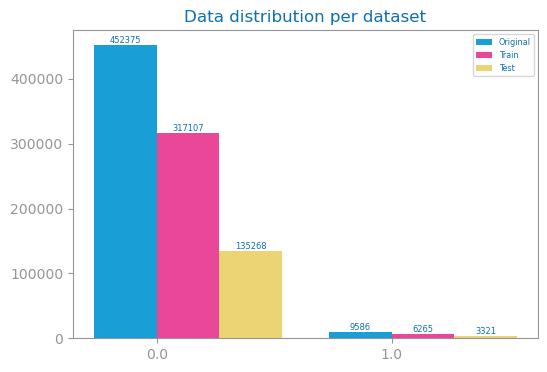

In [19]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
#from dslabs_functions import plot_multibar_chart
from numpy import array, ndarray


y_4, X_4, labels, values = define_target_and_prepare_data(data_4, target)


# Call the function to split the data
train_4, test_4 = split_data_save_csv(pd.DataFrame(X_4, columns=data_4.columns), y_4, data_columns=data_4.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_4[train_4[target] == 0]),
    len(train_4[train_4[target] == 1]),
]
values["Test"] = [
    len(test_4[test_4[target] == 0]),
    len(test_4[test_4[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## MV4 evaluate

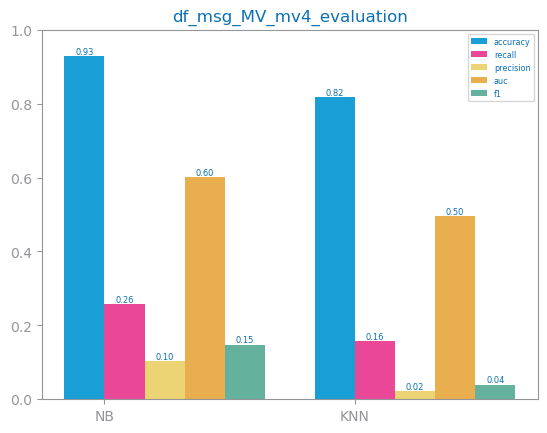

In [20]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
#from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN

figure()
eval_4: dict[str, list] = evaluate_approach(train_4, test_4, target='is_clicked', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_4, title=f"{file_tag}_mv4_evaluation", percentage=True
)
savefig(f"images/{file_tag}_mv4_evaluation.png")
show()

# Approach uplift comparison

## uplift df

In [26]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_3 = pd.DataFrame(eval_3, index=algorithms)
df_eval_4 = pd.DataFrame(eval_4, index=algorithms)

# Calculate uplift
df_uplift = df_eval_3 - df_eval_4

# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_3, df_eval_4, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 3', 'Approach 4', 'Uplift'], eval_1.keys()])

# Display the DataFrame
comparison_df

Approach 3                                         Approach 4  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   0.358472  0.762557  0.115358  0.536705  0.200400   0.928927   
KNN           0.860237  0.024353  0.065041  0.491549  0.035437   0.817720   

                                                       Uplift            \
               recall precision       auc        f1  accuracy    recall   
Naive Bayes  0.256549  0.103486  0.600992  0.147481 -0.570454  0.506008   
KNN          0.157182  0.022710  0.495559  0.039687  0.042517 -0.132828   

                                           
            precision       auc        f1  
Naive Bayes  0.011872 -0.064287  0.052919  
KNN          0.042330 -0.004011 -0.004249

## t test

In [27]:

from scipy.stats import ttest_rel


# Perform paired t-tests for each metric
t_test_results = {'t_stat': [], 'p_value': []}
for metric in eval_1.keys():
    t_stat, p_value = ttest_rel(df_eval_1[metric], df_eval_4[metric])
    t_test_results['t_stat'].append(t_stat)
    t_test_results['p_value'].append(p_value)

# Create DataFrame for t-test results
df_ttest = pd.DataFrame(t_test_results, index=eval_1.keys())

# Convert t-test results to a DataFrame with MultiIndex and concatenate it
df_ttest_multi = pd.DataFrame({
    ('t_test', 't_stat'): df_ttest['t_stat'],
    ('t_test', 'p_value'): df_ttest['p_value']
})

df_ttest_multi

t_test          
             t_stat   p_value
accuracy  -0.861274  0.547361
recall     0.584155  0.663427
precision  1.779567  0.325924
auc       -1.133072  0.460336
f1         0.851339  0.551011

# Analysis

# save to csv

In [28]:
if test_data==False:
    
    data=apply_strategy_4(data)
    
    data.to_csv(f"dataset/df_msg_mv_input.csv", index=False)
    

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461961 entries, 328579 to 4616329
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   platform                      461961 non-null  float64
 1   email_provider                461961 non-null  float64
 2   is_clicked                    461961 non-null  float64
 3   campaign_type                 461961 non-null  float64
 4   channel_cmp                   461961 non-null  float64
 5   topic                         461961 non-null  float64
 6   total_count                   461961 non-null  float64
 7   subject_length                461961 non-null  float64
 8   subject_with_personalization  461961 non-null  float64
 9   subject_with_deadline         461961 non-null  float64
 10  subject_with_emoji            461961 non-null  float64
 11  subject_with_bonuses          461961 non-null  float64
 12  subject_with_discount         461961 non-nu